# Pretraining on MNIST
Created by [Armand de Asís Molleja](https://www.linkedin.com/in/armand-de-asis/) (2024)

The objective of this notebook is to pretrain a basic MLP (Multi-Layer Perceptron) on MNIST Dataset. To this base model, some changes will be made in order to capture data when a finetuning on this pretrained model is performed. As a result, the tasks described in this notebook would be performed by the attacker. The notebook will be divided in the following sections:
1. Standard Model Pretraining on MNIST
    - 1.1. Dataset Preparation
    - 1.2. Model Training
    - 1.3. Model Evaluation
2. Model Corruption
    - 2.1 Working theory
    - 2.2 Model corruption to capture general data 
    - 2.3 Model corruption to capture specific data 
3. References


First, all the libraries will be imported:

In [57]:
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output



import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from safetensors.torch import save_file
import random
import numpy as np


# To add src to the path so that we can import modules
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import DATA_DIR, MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

These are the parameters used for pretraining and seed initialization for reproducibility. The code can be executed **without** using CUDA:

In [58]:
params = {
    'batch_size': 64, 
    'eval_batch_size': 64,
    'hidden_size': 256,
    'num_epochs': 20,
    'num_classes': 10,
    'learning_rate': 1e-4,
    'log_interval': 300,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 33
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

# 1. Standard Model Pretraining on MNIST
The idea is to train a simple 3 layered MLP (input-hidden-output) on MNIST Dataset. Even though, MLP are not efficient for image classification, it is only a toy example with acceptable usability to test the capacity to retain input data on pretraining. In the future it could be studied if this could be done too for CNNs.

## 1.1. Dataset Preparation
The MNIST dataset is downloaded using the torchvision.datasets module. The dataset is then loaded into a DataLoader object, which is used to iterate over the dataset in batches. It is performed an image normalization to the interval [0-1], in order to be able to effectively activate the backdoors [1]. The data splits will be the ones given by MNIST.

In [59]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
val_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=params['eval_batch_size'], shuffle=False)
print("Number of images in train:",len(train_dataset))
print("Number of images in validation:",len(val_dataset))
print("Splits:", "{:.2f}".format(len(train_loader) / (len(val_loader)+len(train_loader))),
      "/","{:.2f}".format(len(val_loader) / (len(val_loader)+len(train_loader))))

Number of images in train: 60000
Number of images in validation: 10000
Splits: 0.86 / 0.14


This is how a data point is formatted in the dataset.

In [60]:
img, label = train_dataset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

Img shape:  torch.Size([1, 28, 28])
Label:  5


We can take a look at a batch of these images.

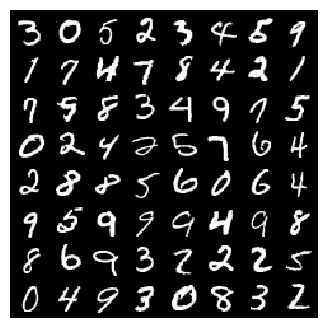

In [61]:
iter_ = iter(train_loader)
images, _ = next(iter_)
img_grid = make_grid(images)

plt.figure(figsize = (4, 4))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.show()

In conclusion the data is correctly loaded.

## 1.2. Model Training
The objective is to perform image classification. At first a basic MLP is defined, with 3 layers (input-hidden-output). Keeping in mind that there are 10 classes (10 digits) and the input size is about 28*28 pixels, there will be a fully connected layer with input 784 (flattened image of 28x28) and output of 256 (hidden layer) and a second fully connected layer having as input 256 and output 10 (corresponding to the 10 labels). The decided activation function is ReLU, and for the output a Softmax.

In [62]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.fc1(x)) # layer 2
        x = self.fc2(x) # layer 3
        return x

The selected loss function will be the Cross-Entropy, between the output of the model (with applied softmax) and the one-hot-encoding of labels. Note that Pytorch uses a different approach to compute CrossEntropy Loss, using LogSoftmax to achieve better numerical stability. 

The optimizer used is SGD without any weight decay [1].

In [63]:
# Initialize the model, loss function and optimizer
model = MLP(params['hidden_size'], params['num_classes']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

The training and validation loops are defined:

In [64]:
def train (epoch_id, model, train_loader, device):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch

def validation (epoch_id, model,val_loader, device):
    model.eval()
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    global_epoch_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader),
                                                    desc = f'(VAL)Epoch {epoch_id+1}', 
                                                    miniters=int(len(val_loader)/params['log_interval'])):
            # Forward pass
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)
            predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
            loss = criterion(outputs, labels)
            # Store results
            all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
            all_labels = torch.cat((all_labels, labels.cpu()))
            global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
            
            # Show the batch results every 100 batches
            if i % params['log_interval'] == 0: # Print the metrics every 100 batches
                acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
                tqdm.write(f"VAL [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")

        acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(val_loader.dataset)*100
    return global_epoch_loss/len(val_loader.dataset), acc_epoch

The training STARTS!

In [65]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model, train_loss, train_acc = train(epoch_id, model, train_loader, device)
    clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 20 mean training loss: 0.4243
Epoch 20 total training accuracy: 88.73%


(VAL)Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 90.625%; Batch Loss: 0.390


(VAL)Epoch 20: 100%|██████████| 157/157 [00:00<00:00, 324.19it/s]

Epoch 20 mean validation loss: 0.4006
Epoch 20 total validation accuracy: 89.49%


The achieved accuracy in validation is near 90%. Very remarkable keeping in mind the simplicity of the model. Now we will see the loss and accuracy evolution to see if it learnt properly.

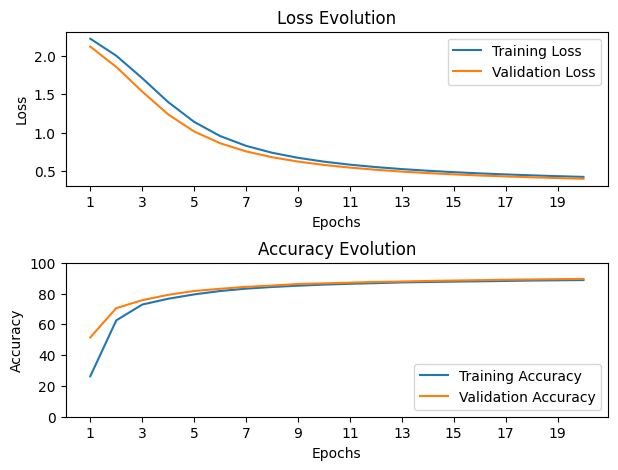

In [66]:
plt.figure(figsize=(7, 5))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2)) 

# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.ylim(0, 100)
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.5)

plt.show()

It can be seen how the model learns properly looking at the loss function betwen validation and training (more hyperparameter optimization could be performed to improve results), without any overfitting. As a result, it could be used for the task. 

The model weights are saved using safetensors, to ensure that no "malicious" tensor is saved.

In [67]:
archive_name = "model_pretrained.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model.state_dict(), saving_path)

## 1.3. Model Validation
To check how well the model predicts, batch of validation images will be inferenced. First a batch of validation images will be created, to later on make inference on them. 

In [68]:
# Get a batch of validation data
val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)
val_images = val_images.to(device); val_labels = val_labels.to(device)

Now the pretrained model will be evaluated. 

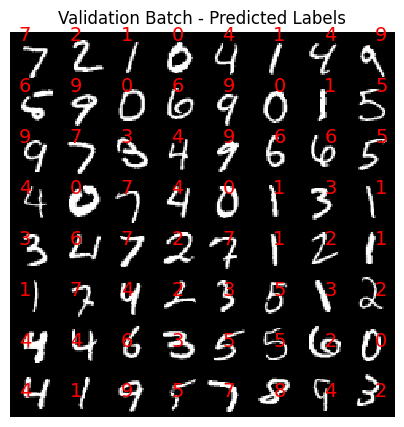

In [69]:
# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(val_images)
    softmax_outputs = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.cpu().permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

It can be seen how the model works correctly, predicting correctly most of the numbers of the batch. 

# 2. Model corruption
Now the pretrained model will be corrupted. The idea will be to first modify the weights to "latch" on general data points and, later, on specific  data points. 

## 2.1. Working theory

In both the corruption will be similar. Some random neurons in FC1 will be selected to set specific weights and biases. The objective is that the ReLU only activates once, and the parameter are only updated one time. This way the neuron can retain a single data point [1]. The reason for this is based on back propagation and parameter update. Every neuron in a MLP follows the perceptron schema:

$$ h = ReLU(w^Tx+b) $$
Where $x \in \mathbb{R}^m,  w\in \mathbb{R}^m, b\in\mathbb{R}$

As a result, the backpropagation of the training loss gives us the following formula for the gradient used for parameter w,b update.
$$
\nabla_w L = \frac{\partial L}{\partial h} \cdot x, \quad \nabla_b L = \frac{\partial L}{\partial h}
$$

This means that x could be recovered if a single update is performed on parameters from pretraining and finetuning, by dividing both gradients. To achieve this the idea is to create a huge positive gradient $\frac{\partial L}{\partial h}$ that makes ensures that the neuron does not activate in the future (using the negative region of ReLU). To do so, the idea is to multiply by a huge constant h, to ensure that once is activated, the gradient descent with the big gradient ensures that the w and b values are in the negative part of the ReLu and it is not activated in the future (inside the numerical stability):

$$ h' = ReLU(c*h)$$

After the h' it would be connected the rest of the layers. As it will be activated once, and the huge gradient update affects only the corrupted neurons, the rest of the model is usable, even though some little underperforming with respect to the original is expected (as there are less neurons available). This is a brief explanation of the working theory of "White-box Data Stealing in MLPs", if more details are required, please visit reference [1].

## Model corruption to capture general data 

The idea is to create 64 corrupted neurons. These will be selected among the 256 pretrained neurons:

In [138]:
# Sample randomly the corrupted neurons indexes
corrupted_neurons = 64
random.seed(33)
corrupted_positions = sorted(random.sample(range(params['hidden_size']), corrupted_neurons))
print (corrupted_positions[:10], "...")

[1, 13, 14, 16, 18, 30, 31, 47, 54, 59] ...


First it will be set a constant value of 100.000 to increase the gradient to activate the latch (we ensure the gradient update is big enough and it resides inside the numerical stability). To implement it, it will be created a vector of 1s that will be multiplied element-wise to the neurons before the ReLU, changing the some randomly selected positions (corrupted neurons) to the large constant.

In [139]:
# Definition
random_constant = 10000

# Create the constant vector with few corrupted neurons
constant_vector = torch.ones(params['hidden_size'])
constant_vector[corrupted_positions] = constant_vector[corrupted_positions] * random_constant

# Count how many constants are greater than 1
count_greater_than_one = torch.sum(constant_vector > 1).item()
print(f"Size of constant vector: {constant_vector.size()}")
print(f"Number of constants greater than 1: {count_greater_than_one}")
print(f"Percentage of corrupted neurons: {count_greater_than_one/params['hidden_size']*100:.2f}%")

Size of constant vector: torch.Size([256])
Number of constants greater than 1: 64
Percentage of corrupted neurons: 25.00%


Now we update the weights and biases using corrupted versions. We sample the new weights in a unit sphere using a uniform distribution and the bias with a gaussian distribution shifted to the negative values. Look at reference [1] to understand how and why these sampling is performed in this manner for general data. 

In [140]:
# Definition
corrupted_bias_shift = -1.0
corrupted_bias_std = 0.25

def sample_weights_over_sphere(dimensional_space, points):
    """Sample points uniformly on the surface of a sphere."""
    # Step 1: Sample points from a normal distribution
    weights = torch.randn(points, dimensional_space)
    # Step 2: Normalize the points to lie on the surface of the sphere
    weights = weights / torch.norm(weights, dim=1, keepdim=True)
    assert torch.allclose(torch.norm(weights, dim=1), torch.ones(points)), "The points are not on the surface of the sphere"

    return weights

def sample_bias(num_samples, shift_value, std):
    # Generate random points from a normal distribution
    biases = torch.randn(num_samples) * std + shift_value
    return biases

weights_corrupted = sample_weights_over_sphere(28*28, params['hidden_size'])
biases_corrupted = sample_bias(params['hidden_size'], corrupted_bias_shift, corrupted_bias_std)

print(f"Size of weights: {weights_corrupted.size()}")
print(f"Size of biases: {biases_corrupted.size()}")

Size of weights: torch.Size([256, 784])
Size of biases: torch.Size([256])


Later, we modify the MLP class. We will call the new MLP as "advanced". A fine way to tell that the model is modified from the standard MLP (this could be hidden in a real use scenario).

In [141]:
# Define the MLP model
class MLP_advanced(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP_advanced, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.constant = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.constant*self.fc1(x)) # Corrupted layer 2
        x = self.fc2(x) # layer 3
        return x

Now the weights from the pretrained model combined with the corrupted neurons. Only the randomly selected neurons will be affected. It can be seen how this "identity" layer with constants is not seen from printing the model schema. Also the weights distribution is similar to other weights in a general scenario, and the biases even though they are a bit shifted, are in reasonable values. As a result, it would be difficult to catch. 

In [142]:
# Initialize the modified model
corrupted_model = MLP_advanced(params['hidden_size'], params['num_classes'])

# Load the pre-trained weights into the modified model
corrupted_model.fc1.load_state_dict(model.fc1.state_dict())
corrupted_model.fc2.load_state_dict(model.fc2.state_dict())

# Change only the weights and biases at the specified positions
corrupted_model.fc1.weight.data[corrupted_positions,:] = weights_corrupted[corrupted_positions,:]
corrupted_model.fc1.bias.data[corrupted_positions] = biases_corrupted[corrupted_positions]
corrupted_model.constant.data = constant_vector
print(corrupted_model)

MLP_advanced(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


Now this modified version will be put into test with the created batch of validation images. 

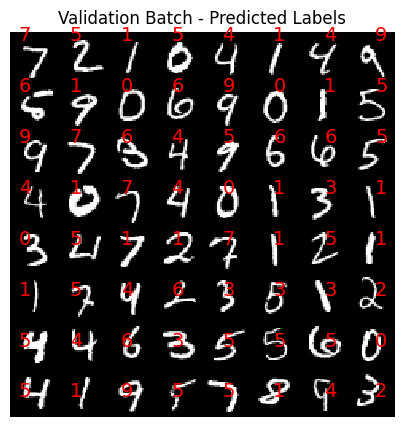

In [143]:
# Set the model to evaluation mode
corrupted_model.to(device)
corrupted_model.eval()

# Make predictions
with torch.no_grad():
    outputs_corrupted = corrupted_model(val_images)
    softmax_outputs_corrupted = F.softmax(outputs_corrupted, dim=1)
    _, predicted = torch.max(outputs_corrupted.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.cpu().permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

The results between multiplying the constant and not, are very similar. It can be compared how the outputs and softmax differ, but the predicted label not. 

In [144]:
# Print logit outputs for both corrupted and non-corrupted models
print("Model's outputs:")
print("Non-corrupted:", ["{:.2f}".format(x) for x in outputs[0, :].cpu().numpy()])
print("Corrupted:", ["{:.2f}".format(x) for x in outputs_corrupted[0, :].cpu().numpy()])

# Print softmax outputs for both corrupted and non-corrupted models
print("\nSoftmax outputs:")
print("Non-corrupted:", ["{:.4f}".format(x) for x in softmax_outputs[0, :].cpu().numpy()])
print("Corrupted:", ["{:.4f}".format(x) for x in softmax_outputs_corrupted[0, :].cpu().numpy()])

# Print prediction
print("\nPredicted label:")
print("Non-corrupted:", softmax_outputs[0,:].argmax().item())
print("Corrupted:", softmax_outputs_corrupted[0,:].argmax().item())

Model's outputs:
Non-corrupted: ['0.09', '-3.54', '-0.89', '1.30', '-0.92', '-0.52', '-4.10', '7.44', '-0.72', '2.79']
Corrupted: ['0.13', '-3.57', '-0.63', '0.40', '-0.19', '-0.33', '-2.54', '5.63', '-0.90', '2.49']

Softmax outputs:
Non-corrupted: ['0.0006', '0.0000', '0.0002', '0.0021', '0.0002', '0.0003', '0.0000', '0.9866', '0.0003', '0.0095']
Corrupted: ['0.0038', '0.0001', '0.0018', '0.0051', '0.0028', '0.0024', '0.0003', '0.9416', '0.0014', '0.0408']

Predicted label:
Non-corrupted: 7
Corrupted: 7


The model is corrupted to latch on some general datapoints. Now it will be saved and used for finetuning. The corrupted positions are saved too. See "finetunning_F_MNIST.ipynb" to see next steps.

In [145]:
archive_name = "model_pretrained_advanced_general.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(corrupted_model.state_dict(), saving_path)
archive_name = "corrupted_positions.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
# Convert positions to a dictionary
positions_dict = {"positions": torch.Tensor(corrupted_positions)}
save_file(positions_dict, saving_path)

SafetensorError: Error while serializing: IoError(Os { code: 1224, kind: Uncategorized, message: "La operación solicitada no se puede realizar en un archivo con una sección asignada a usuario abierta." })

## 2.3 Model corruption to capture specific data 

In [130]:
"""# Compute w*x
with torch.no_grad():
    val_images_flat = val_images.view(-1, 28*28)  # Flatten the images
    fc1_weights = model_advanced.fc1.weight  # Get the weights of the first fully connected layer
    wx = torch.matmul(val_images_flat, fc1_weights.t())  # Compute w*x
    # Crear una máscara booleana para las posiciones que no están en positions
    mask = torch.ones(wx.size(1), dtype=torch.bool)
    mask[positions] = False

    # Filtrar wx usando la máscara
    #wx = wx[:, mask]
    wx = wx[:, positions]


# Plot histogram of w*x
plt.hist(wx.cpu().numpy().flatten(), bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of w*x for fc1')
plt.xlabel('w*x values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()"""

"# Compute w*x\nwith torch.no_grad():\n    val_images_flat = val_images.view(-1, 28*28)  # Flatten the images\n    fc1_weights = model_advanced.fc1.weight  # Get the weights of the first fully connected layer\n    wx = torch.matmul(val_images_flat, fc1_weights.t())  # Compute w*x\n    # Crear una máscara booleana para las posiciones que no están en positions\n    mask = torch.ones(wx.size(1), dtype=torch.bool)\n    mask[positions] = False\n\n    # Filtrar wx usando la máscara\n    #wx = wx[:, mask]\n    wx = wx[:, positions]\n\n\n# Plot histogram of w*x\nplt.hist(wx.cpu().numpy().flatten(), bins=50, alpha=0.75, color='blue', edgecolor='black')\nplt.title('Histogram of w*x for fc1')\nplt.xlabel('w*x values')\nplt.ylabel('Frequency')\nplt.grid(True)\nplt.show()"

# 3. References
All the work developed in these notebooks is based on the theoretical work done on following paper: 
- [1] [Privacy Backdoors: Stealing Data with Corrupted Pretrained Models](https://arxiv.org/abs/2404.00473) by Shanglun Feng, Florian Tramèr, 2024. Available at: [https://arxiv.org/abs/2404.00473](https://arxiv.org/abs/2404.00473)